In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import humanize
import plotly.express as px
import warnings
import pymongo
import os

In [2]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')

In [3]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

chapinero = apartments.loc[apartments['localidad'] == 'CHAPINERO']
chapinero.head()

codigo tipo_propiedad tipo_operacion  precio_venta  \
6    3390-M4320821    APARTAMENTO          VENTA  3.670000e+09   
17    897-M4156030    APARTAMENTO          VENTA  3.900000e+08   
18      11301-1492    APARTAMENTO          VENTA  2.100000e+09   
19  11013-M4424136    APARTAMENTO          VENTA  8.450000e+08   
20    293-M3798297    APARTAMENTO          VENTA  1.700000e+09   

    precio_arriendo    area  habitaciones  banos  administracion  \
6               NaN  432.00           4.0    5.0       3000000.0   
17              NaN   40.00           1.0    2.0             NaN   
18              NaN  350.00           3.0    4.0       2040000.0   
19              NaN  138.96           3.0    4.0       1170000.0   
20              NaN  178.00           3.0    4.0       1128000.0   

    parqueaderos  ... permite_mascotas  gimnasio ascensor conjunto_cerrado  \
6            4.0  ...              0.0       0.0      1.0              1.0   
17           1.0  ...              0.0       0.0      1.0              0.0   
18           3.0  ...              0.0       1.0      1.0              0.0   
19           2.0  ...              0.0       0.0      1.0              0.0   
20           3.0  ...              0.0       1.0      1.0              0.0   

    coords_modified  localidad                  barrio estacion_tm_cercana  \
6             False  CHAPINERO           S.C. EL NOGAL   Héroes - Gel´Hada   
17            False  CHAPINERO  S.C. CHAPINERO CENTRAL            Calle 57   
18            False  CHAPINERO          CHICO ORIENTAL            Calle 85   
19            False  CHAPINERO        S.C. CHICO NORTE              Virrey   
20            False  CHAPINERO                 ZAMUDIO              Flores   

   distancia_estacion_tm_m is_cerca_estacion_tm  
6                   960.91                    0  
17                  242.21                    1  
18                 2151.16                    0  
19                 1115.25                    0  
20                 1138.96                    0  

[5 rows x 40 columns]

In [4]:
# apartments = pd.read_csv('../../data/processed/apartments.csv', low_memory=False)
# chapinero =  apartments[(apartments['tipo_operacion'] == 'VENTA') & (apartments['localidad'] == 'CHAPINERO') & (apartments['coords_modified'] == False)]
# chapinero = chapinero.drop(columns=['precio_arriendo'])
# chapinero.head()

In [5]:
chapinero.datetime = pd.to_datetime(chapinero.datetime)
chapinero.fecha_actualizacion_precio_venta = pd.to_datetime(chapinero.fecha_actualizacion_precio_venta)

In [6]:
chapinero.shape

(12870, 40)

In [7]:
chapinero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12870 entries, 6 to 84733
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   codigo                               12870 non-null  object        
 1   tipo_propiedad                       12870 non-null  object        
 2   tipo_operacion                       12870 non-null  object        
 3   precio_venta                         12870 non-null  float64       
 4   precio_arriendo                      93 non-null     float64       
 5   area                                 12870 non-null  float64       
 6   habitaciones                         12870 non-null  float64       
 7   banos                                12870 non-null  float64       
 8   administracion                       11738 non-null  float64       
 9   parqueaderos                         12870 non-null  float64       
 10  sector         

In [8]:
chapinero.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta',
       'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion',
       'parqueaderos', 'sector', 'estrato', 'antiguedad', 'estado', 'longitud',
       'latitud', 'descripcion', 'datetime', 'website', 'compañia',
       'last_view', 'fecha_actualizacion_precio_venta',
       'precio_venta_anterior', 'fecha_actualizacion_precio_arriendo',
       'precio_arriendo_anterior', 'direccion', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'coords_modified', 'localidad', 'barrio',
       'estacion_tm_cercana', 'distancia_estacion_tm_m',
       'is_cerca_estacion_tm'],
      dtype='object')

In [9]:
def format_tick_humanize(value, tick_number):
    return humanize.intword(value)

# Eliminar outliers

Eliminamos los precios que son outliers

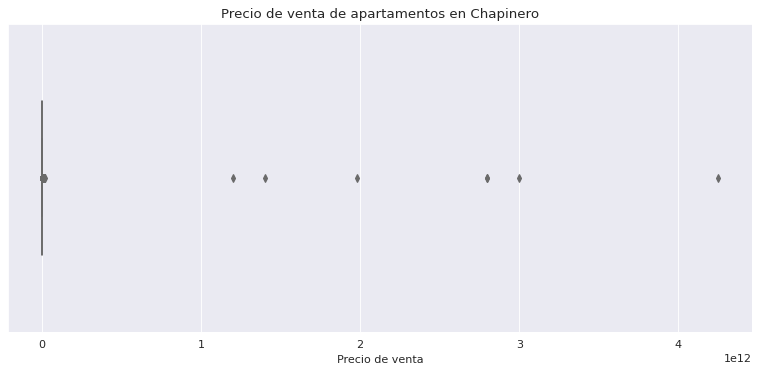

In [10]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    chapinero,
    x='precio_venta',
    width=.5,
    palette='Set3',
)

plt.title('Precio de venta de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.show()

In [11]:
Q1 = chapinero['precio_venta'].quantile(0.25)
Q3 = chapinero['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
if lower < 0:
    lower = Q1 - (0.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = chapinero[(chapinero['precio_venta'] < lower) | (chapinero['precio_venta'] > upper)]
outliers.shape

(828, 40)

In [12]:
chapinero = chapinero[(chapinero['precio_venta'] > lower) & (chapinero['precio_venta'] < upper)]
chapinero.shape

(12042, 40)

# Analisis Univariado

## Area (m2)

### Eliminar outliers

In [13]:
# eliminar area igual a 0

chapinero = chapinero[chapinero['area'] > 0]

Eliminamos las areas (m2) que son outliers

In [14]:
Q1 = chapinero['area'].quantile(0.25)
Q3 = chapinero['area'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = chapinero[(chapinero['area'] < lower) | (chapinero['area'] > upper)]
outliers.shape

(144, 40)

In [15]:
chapinero = chapinero[(chapinero['area'] > lower) & (chapinero['area'] < upper)]
chapinero.shape

(11858, 40)

### Analisis

In [16]:
chapinero.area.describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

count                mean                std  min   25%    50%  \
area  11,858.0  163.56043514926634  83.42624714959322  1.0  96.0  153.0   

        75%    max  
area  220.0  410.0

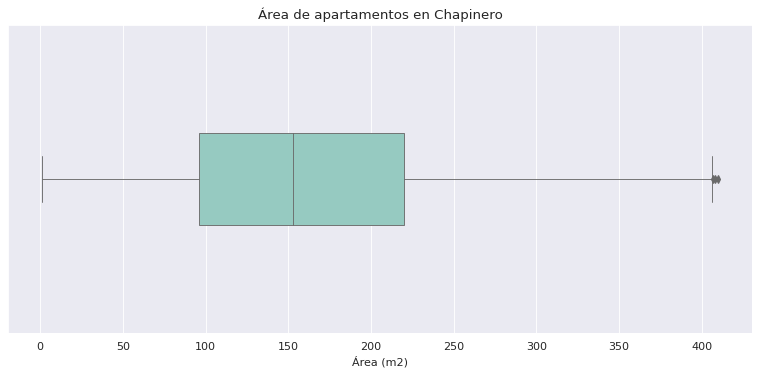

In [17]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=chapinero,
    x='area',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Área de apartamentos en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

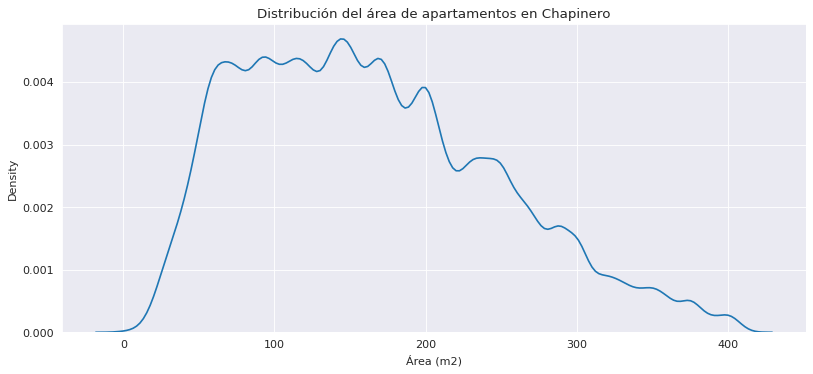

In [18]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='area',
    bw_adjust=.5,
)

plt.title('Distribución del área de apartamentos en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

### Cercania a Transmilenio

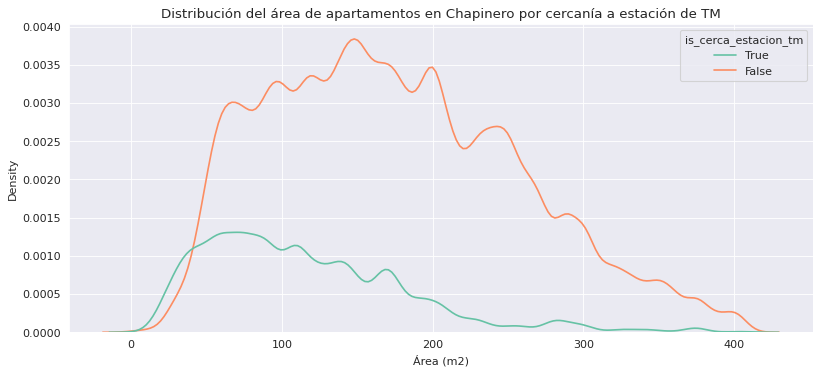

In [19]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='area',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('Distribución del área de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.show()

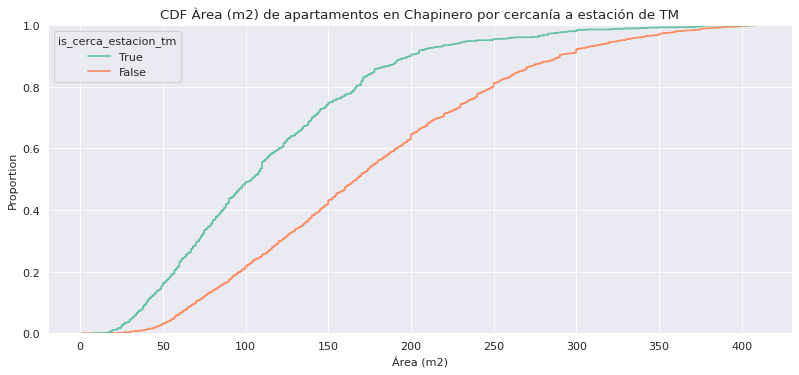

In [20]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='area',
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('CDF Àrea (m2) de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.show()


### Estrato

In [21]:
chapinero.groupby('estrato')['area'].describe().applymap(lambda x: round(x, 1))

count   mean    std    min    25%    50%    75%    max
estrato                                                         
0.0        10.0  242.7  121.8  108.0  128.5  221.0  366.0  400.0
1.0        19.0  151.9   80.0   29.0  107.2  139.0  173.3  361.0
2.0        11.0   86.4   89.1   27.0   30.5   64.0   85.1  325.0
3.0       269.0   62.1   43.2    6.9   35.0   46.1   74.0  280.0
4.0      1179.0   85.4   51.2   14.0   52.8   72.0  100.0  344.0
5.0      1220.0  130.3   64.7   17.0   83.0  117.3  170.0  400.0
6.0      9143.0  181.0   80.5    1.0  119.0  171.4  237.2  410.0

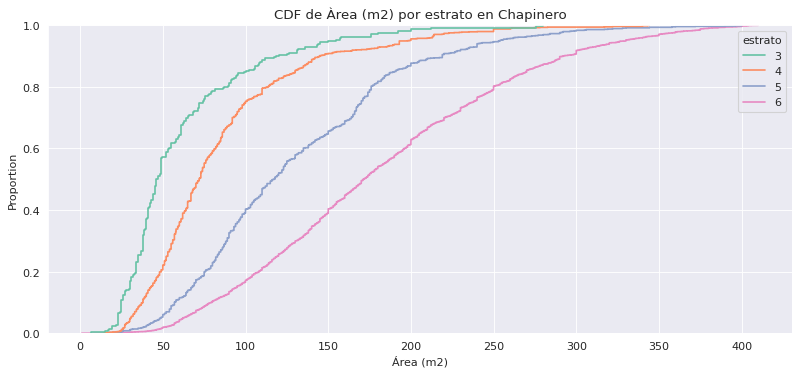

In [22]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='area',
    hue='estrato',
    palette='Set2',
    hue_order=[3, 4, 5, 6],
)

plt.title('CDF de Àrea (m2) por estrato en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

### Antiguedad

In [23]:
chapinero.groupby('antiguedad')['area'].describe().applymap(lambda x: round(x, 1))

count   mean   std   min    25%    50%    75%    max
antiguedad                                                               
ENTRE 0 Y 5 ANOS    1754.0  124.7  74.2   1.0   62.1  113.0  171.7  404.0
ENTRE 10 Y 20 ANOS  2591.0  163.2  82.8   8.0   95.0  150.0  220.0  408.0
ENTRE 5 Y 10 ANOS   1889.0  147.4  77.6   6.9   81.4  135.0  200.0  381.2
MAS DE 20 ANOS      5171.0  180.4  82.8   4.0  116.0  170.0  237.3  410.0
REMODELADO           447.0  190.0  86.2  26.0  130.0  191.0  240.7  406.0

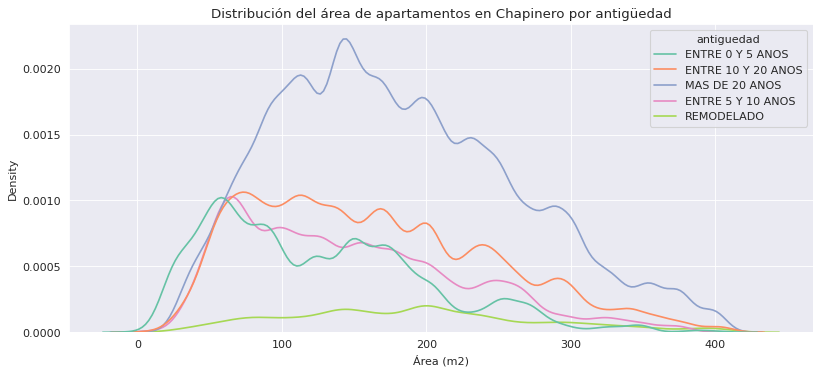

In [24]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='area',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en Chapinero por antigüedad')
plt.xlabel('Área (m2)')
plt.show()

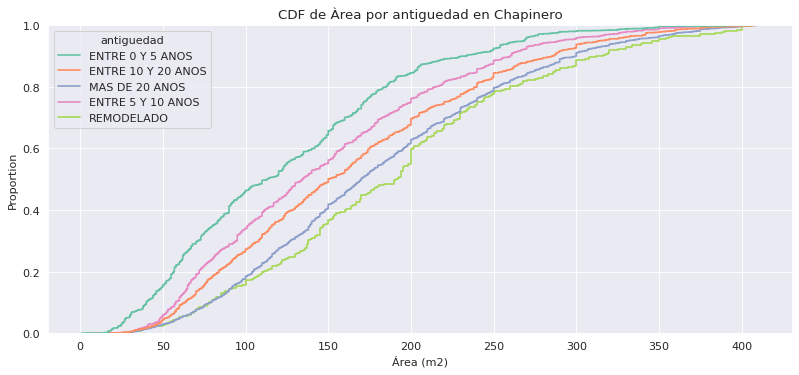

In [25]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='area',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de Àrea por antiguedad en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

Lo apartamentos mas recientes tienden a tener un Àrea menor que los mas antiguos

### Estacion de TM Cercana

In [26]:
estacion_tm_cercana = chapinero[chapinero['is_cerca_estacion_tm'] == True]
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='mean', ascending=False)
estacion_tm_cercana_stats

count   mean   std   min   25%    50%    75%  \
estacion_tm_cercana                                                            
Virrey                          470.0  144.8  73.7  38.0  85.1  129.0  197.9   
Héroes - Gel´Hada                27.0  133.7  77.2  42.0  98.0  116.0  138.0   
Calle 85                        467.0  128.0  55.9  31.8  84.0  120.2  167.0   
Calle 100 - Marketmedios        627.0  126.5  63.9  17.0  78.0  121.0  159.5   
Calle 72                         28.0  114.5  66.7  40.0  70.7   82.9  177.2   
Flores                           42.0  108.4  64.9  30.0  62.2  104.4  129.8   
Calle 76 - San Felipe            64.0   99.9  59.0  17.1  53.8   99.0  123.0   
AV. 39                           31.0   79.5  35.2  29.0  50.8   85.0  112.4   
Calle 45 - American School Way   91.0   72.6  42.1  25.0  38.0   57.0   94.0   
Marly                            94.0   67.5  41.5  25.0  38.2   59.0   82.2   
Calle 63                        147.0   67.0  45.3  15.0  40.0   49.0   79.1   
Calle 57                        178.0   55.1  39.7   6.9  27.4   40.0   66.5   

                                  max  
estacion_tm_cercana                    
Virrey                          408.0  
Héroes - Gel´Hada               360.0  
Calle 85                        400.0  
Calle 100 - Marketmedios        378.0  
Calle 72                        260.0  
Flores                          370.0  
Calle 76 - San Felipe           321.2  
AV. 39                          134.2  
Calle 45 - American School Way  193.0  
Marly                           265.0  
Calle 63                        343.0  
Calle 57                        230.0

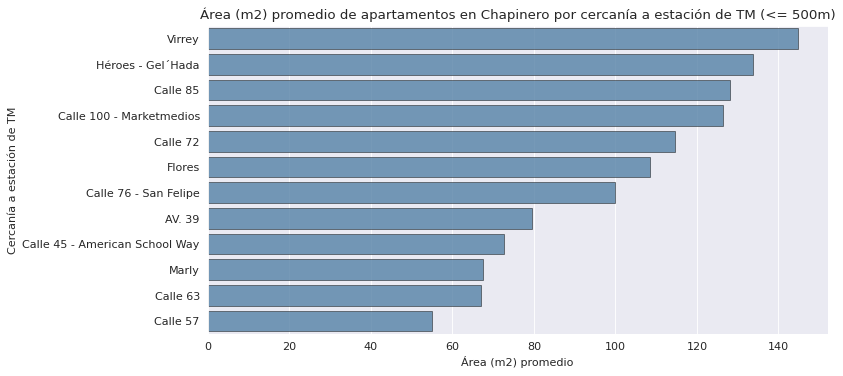

In [27]:
plt.figure(figsize=(10, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='mean',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) promedio de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) promedio')
plt.ylabel('Cercanía a estación de TM')
plt.show()

In [28]:
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='50%', ascending=False)

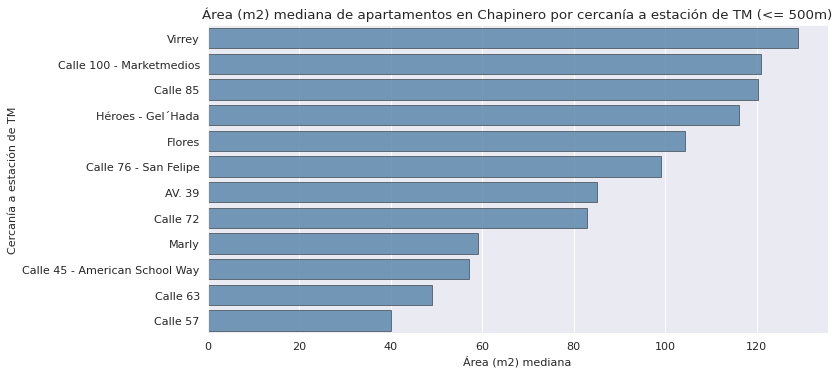

In [29]:
plt.figure(figsize=(10, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='50%',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) mediana de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) mediana')
plt.ylabel('Cercanía a estación de TM')
plt.show()

<Figure size 800x400 with 0 Axes>

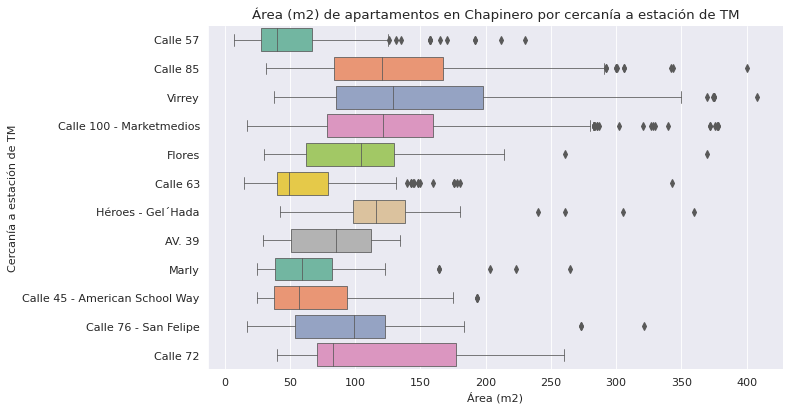

In [30]:
plt.figure(figsize=(10, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='area',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Área (m2) de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.ylabel('Cercanía a estación de TM')
plt.show()

## Precio de venta

In [68]:
fig = px.scatter_mapbox(
    chapinero,
    lat='latitud',
    lon='longitud',
    color='precio_venta',
    size='area',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    mapbox_style='open-street-map',
    # mapbox_style='dark',
    title='Precio de venta y área de apartamentos en Chapinero',
    hover_name='barrio',
    hover_data=['area', 'precio_venta', 'estrato', 'antiguedad', 'is_cerca_estacion_tm', 'estacion_tm_cercana'],
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title='Precio de venta',
        tickformat='s',
    ),
)

# save plot
fig.write_html('../../html/precio_venta_area_chapinero.html')

fig.show()

In [32]:
chapinero.precio_venta.describe().apply(lambda x: humanize.intword(x)).to_frame().T

count         mean            std            min  \
precio_venta  11.9 thousand  1.4 billion  805.9 million  150.0 million   

                        25%          50%          75%          max  
precio_venta  700.0 million  1.2 billion  1.8 billion  3.9 billion

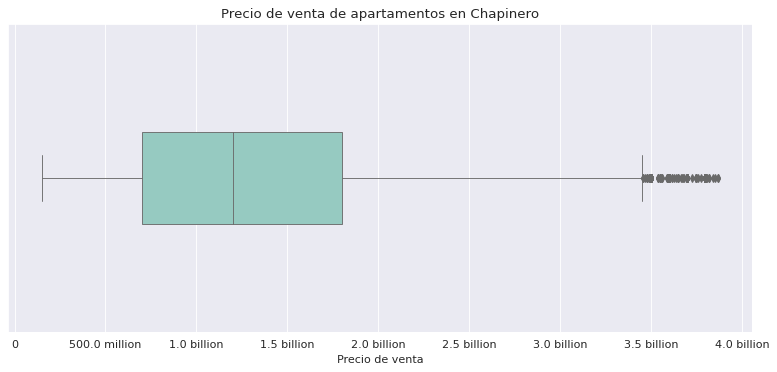

In [33]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    chapinero,
    x='precio_venta',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

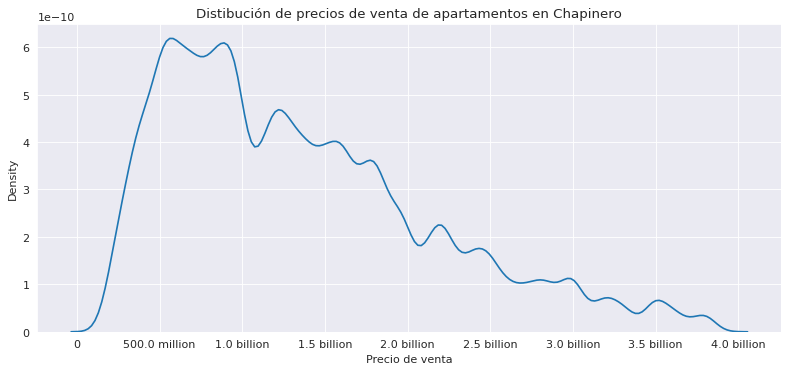

In [34]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [35]:
stat, p = stats.normaltest(chapinero['precio_venta'])
print('stat=%.3f, p=%.3f' % (stat, p))

stat=1115.183, p=0.000


In [36]:
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Probably not Gaussian


### Barrios

In [37]:
top_barrios = chapinero.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

# escoger los que tienen más de 20 registros para que sea más representativo
top_barrios_mean = top_barrios[top_barrios['count'] > 22].sort_values('mean', ascending=False).head(10)
top_barrios_mean.applymap(lambda x: humanize.intword(x))

count         mean       median            std
barrio                                                                      
URB. BELMONTE                    25  2.1 billion  2.1 billion  722.5 million
LA CABRERA                      546  2.0 billion  2.0 billion  791.9 million
ALTOS DE BELLAVISTA              29  1.9 billion  1.6 billion  819.3 million
CHICO ALTO                      197  1.9 billion  1.7 billion  700.7 million
PINAR ALTO - PINAR II            59  1.9 billion  1.3 billion  766.9 million
CHICO ORIENTAL                  223  1.8 billion  1.7 billion  777.7 million
S.C. EL BAGAZAL                  35  1.8 billion  1.6 billion  864.4 million
S.C. EL RETIRO                  213  1.8 billion  1.7 billion  768.8 million
BOSQUE EL RETIRO I SECTOR       269  1.7 billion  1.5 billion  796.8 million
BELLAVISTA - URB. EL CASTILLO    23  1.7 billion  1.7 billion  431.0 million

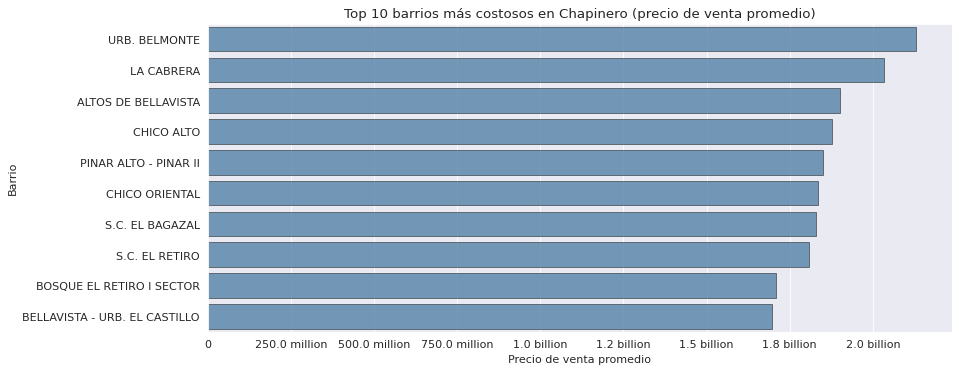

In [38]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_mean,
    y=top_barrios_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Chapinero (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [39]:
top_barrios_median = top_barrios[top_barrios['count'] > 22].sort_values('median', ascending=False).head(10)
top_barrios_median.applymap(lambda x: humanize.intword(x))

count         mean       median            std
barrio                                                                      
URB. BELMONTE                    25  2.1 billion  2.1 billion  722.5 million
LA CABRERA                      546  2.0 billion  2.0 billion  791.9 million
ZAMUDIO                          61  1.6 billion  1.7 billion  590.1 million
CHICO ALTO                      197  1.9 billion  1.7 billion  700.7 million
S.C. EL RETIRO                  213  1.8 billion  1.7 billion  768.8 million
CHICO ORIENTAL                  223  1.8 billion  1.7 billion  777.7 million
BELLAVISTA - URB. EL CASTILLO    23  1.7 billion  1.7 billion  431.0 million
SIERRAS DEL CHICO                27  1.5 billion  1.6 billion  698.2 million
ALTOS DE BELLAVISTA              29  1.9 billion  1.6 billion  819.3 million
S.C. EL BAGAZAL                  35  1.8 billion  1.6 billion  864.4 million

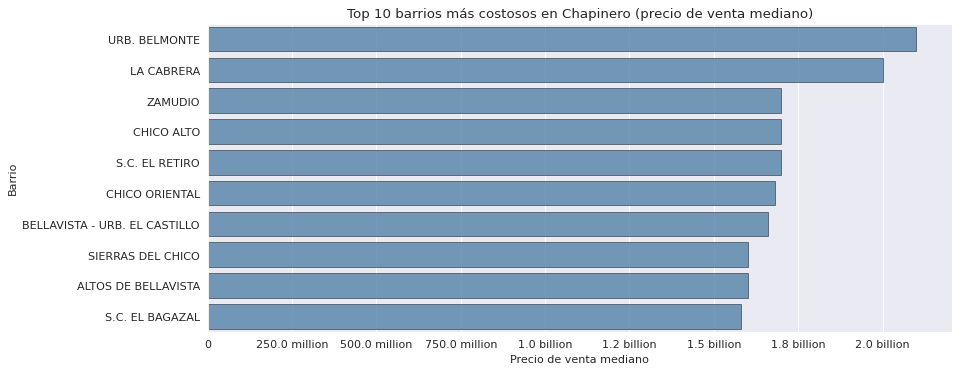

In [40]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_median,
    y=top_barrios_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Chapinero (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [41]:
top_barrios_economicos = chapinero.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

top_barrios_economicos_mean = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('mean', ascending=True).head(10)
top_barrios_economicos_mean.applymap(lambda x: humanize.intword(x))

count           mean         median  \
barrio                                                                  
LOS OLIVOS                           22  317.2 million  247.5 million   
S.C. CHAPINERO CENTRAL              285  350.6 million  320.0 million   
S.C. SUCRE                           73  396.8 million  350.0 million   
S.C. MARLY                           85  407.1 million  337.0 million   
S.C. PARDO RUBIO                    164  454.0 million  404.5 million   
S.C. CATALUNA                        22  476.5 million  411.5 million   
BOSQUE CALDERON TEJADA III SECTOR    12  477.8 million  460.0 million   
S.C. CHAPINERO NORTE                 90  491.3 million  455.0 million   
S.C. LA SALLE                       130  515.5 million  487.5 million   
S.C. BOSQUE CALDERON                136  532.4 million  497.5 million   

                                             std  
barrio                                            
LOS OLIVOS                         213.6 million  
S.C. CHAPINERO CENTRAL             164.7 million  
S.C. SUCRE                         172.1 million  
S.C. MARLY                         314.4 million  
S.C. PARDO RUBIO                   221.4 million  
S.C. CATALUNA                      251.9 million  
BOSQUE CALDERON TEJADA III SECTOR   91.5 million  
S.C. CHAPINERO NORTE               210.4 million  
S.C. LA SALLE                      180.3 million  
S.C. BOSQUE CALDERON               217.1 million

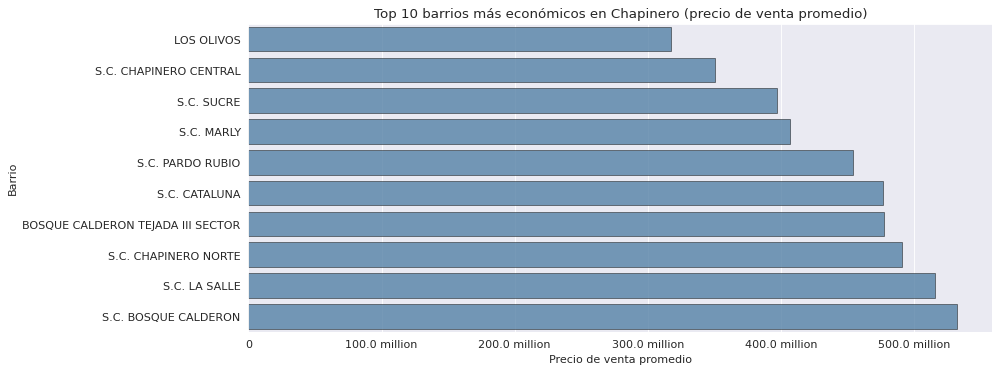

In [42]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_mean,
    y=top_barrios_economicos_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Chapinero (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [43]:
top_barrios_economicos_median = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('median', ascending=True).head(10)
top_barrios_economicos_median.applymap(lambda x: humanize.intword(x))

count           mean         median  \
barrio                                                                  
LOS OLIVOS                           22  317.2 million  247.5 million   
S.C. CHAPINERO CENTRAL              285  350.6 million  320.0 million   
S.C. MARLY                           85  407.1 million  337.0 million   
S.C. SUCRE                           73  396.8 million  350.0 million   
S.C. PARDO RUBIO                    164  454.0 million  404.5 million   
S.C. CATALUNA                        22  476.5 million  411.5 million   
S.C. CHAPINERO NORTE                 90  491.3 million  455.0 million   
BOSQUE CALDERON TEJADA III SECTOR    12  477.8 million  460.0 million   
S.C. MARIA CRISTINA                 113  553.7 million  465.0 million   
S.C. LA SALLE                       130  515.5 million  487.5 million   

                                             std  
barrio                                            
LOS OLIVOS                         213.6 million  
S.C. CHAPINERO CENTRAL             164.7 million  
S.C. MARLY                         314.4 million  
S.C. SUCRE                         172.1 million  
S.C. PARDO RUBIO                   221.4 million  
S.C. CATALUNA                      251.9 million  
S.C. CHAPINERO NORTE               210.4 million  
BOSQUE CALDERON TEJADA III SECTOR   91.5 million  
S.C. MARIA CRISTINA                291.9 million  
S.C. LA SALLE                      180.3 million

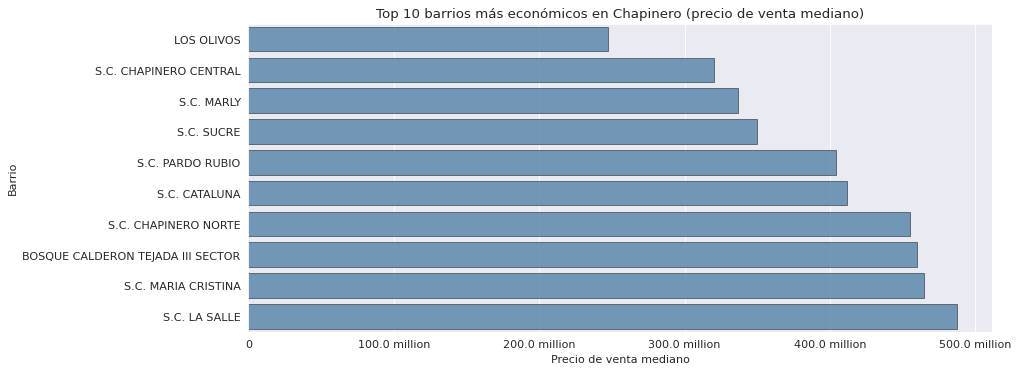

In [44]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_median,
    y=top_barrios_economicos_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Chapinero (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Cercania a Transmilenio

In [45]:
chapinero.groupby('is_cerca_estacion_tm')['precio_venta'].describe().applymap(lambda x: humanize.intcomma(x))

count                   mean                  std  \
is_cerca_estacion_tm                                                        
0                     9,592.0  1,462,605,304.0064638  803,802,748.3568907   
1                     2,266.0     890,333,028.631068  631,884,365.2752024   

                                min            25%              50%  \
is_cerca_estacion_tm                                                  
0                     180,000,000.0  821,500,000.0  1,320,000,000.0   
1                     150,000,000.0  460,000,000.0    717,500,000.0   

                                  75%              max  
is_cerca_estacion_tm                                    
0                     1,930,000,000.0  3,870,000,000.0  
1                     1,101,500,000.0  3,870,000,000.0

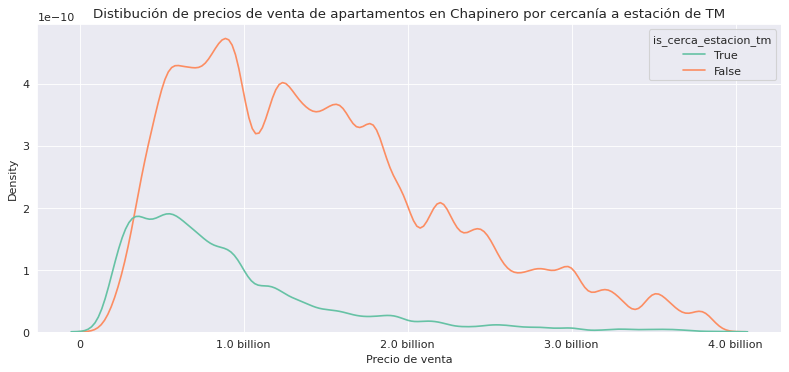

In [46]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

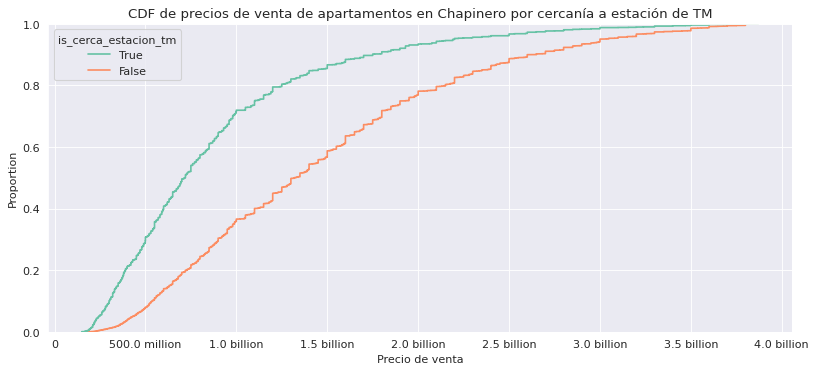

In [47]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estrato

In [48]:
chapinero.groupby('estrato')['precio_venta'].describe().applymap(lambda x: humanize.intword(x))

count           mean            std            min  \
estrato                                                              
0.0                10    1.9 billion    1.1 billion  660.0 million   
1.0                19    1.1 billion  745.4 million  198.0 million   
2.0                11  651.1 million  659.5 million  235.0 million   
3.0               269  374.1 million  219.2 million  175.0 million   
4.0      1.2 thousand  577.3 million  396.4 million  150.0 million   
5.0      1.2 thousand    1.0 billion  621.3 million  170.0 million   
6.0      9.1 thousand    1.5 billion  785.8 million  229.0 million   

                   25%            50%            75%          max  
estrato                                                            
0.0      962.5 million    1.8 billion    2.5 billion  3.8 billion  
1.0      587.5 million  825.0 million    1.3 billion  2.8 billion  
2.0      260.5 million  380.0 million  624.0 million  2.4 billion  
3.0      260.0 million  320.0 million  390.0 million  1.8 billion  
4.0      360.0 million  465.0 million  640.0 million  3.6 billion  
5.0      593.8 million  875.0 million    1.4 billion  3.8 billion  
6.0      895.0 million    1.4 billion    2.0 billion  3.9 billion

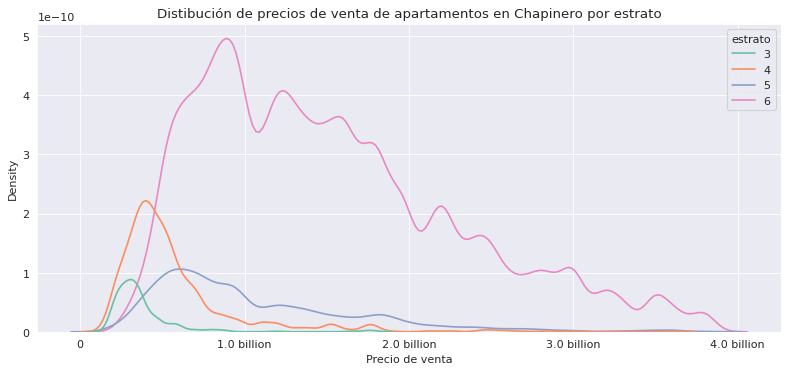

In [49]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[3, 4, 5, 6],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

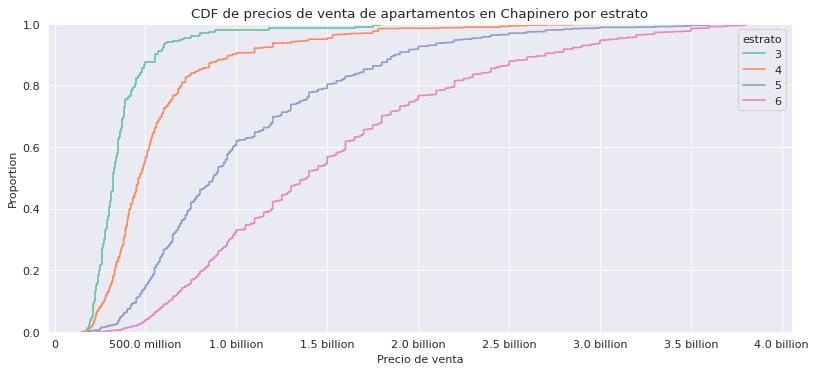

In [50]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='precio_venta',
    hue='estrato',
    hue_order=[3, 4, 5, 6],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Chapinero por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [51]:
chapinero.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta',
       'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion',
       'parqueaderos', 'sector', 'estrato', 'antiguedad', 'estado', 'longitud',
       'latitud', 'descripcion', 'datetime', 'website', 'compañia',
       'last_view', 'fecha_actualizacion_precio_venta',
       'precio_venta_anterior', 'fecha_actualizacion_precio_arriendo',
       'precio_arriendo_anterior', 'direccion', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'coords_modified', 'localidad', 'barrio',
       'estacion_tm_cercana', 'distancia_estacion_tm_m',
       'is_cerca_estacion_tm'],
      dtype='object')

### Antiguedad del apartamento

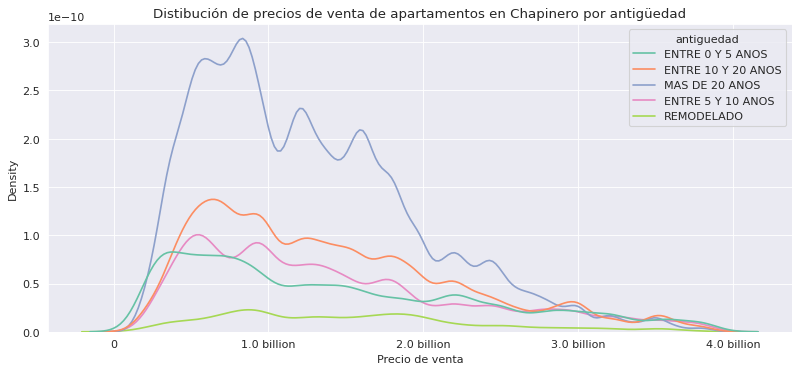

In [52]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

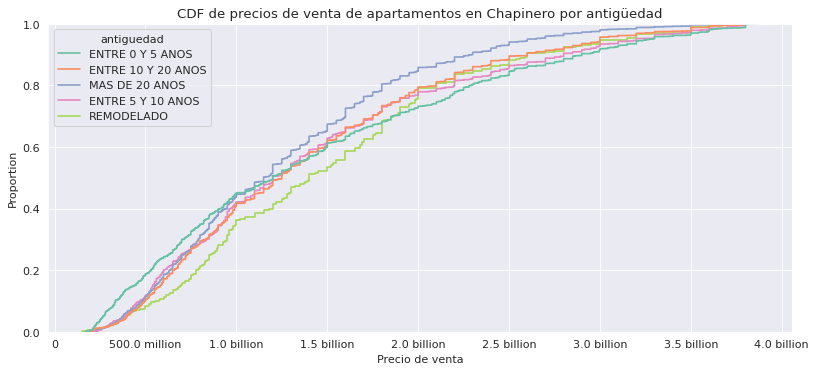

In [53]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='precio_venta',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Chapinero por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estacion de TM Cercana

In [54]:
estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False).applymap(lambda x: humanize.intword(x))

count           mean            std  \
estacion_tm_cercana                                                  
Virrey                           470    1.2 billion  750.1 million   
Calle 85                         467    1.2 billion  644.8 million   
Héroes - Gel´Hada                 27  958.1 million  884.7 million   
Calle 100 - Marketmedios         627  904.8 million  479.6 million   
Calle 72                          28  712.7 million  300.6 million   
Calle 76 - San Felipe             64  635.5 million  389.6 million   
Flores                            42  629.3 million  351.0 million   
Marly                             94  403.5 million  296.6 million   
Calle 45 - American School Way    91  402.7 million  183.9 million   
AV. 39                            31  401.6 million  143.5 million   
Calle 63                         147  384.5 million  181.4 million   
Calle 57                         178  351.0 million  168.2 million   

                                          min            25%            50%  \
estacion_tm_cercana                                                           
Virrey                          217.0 million  680.0 million  950.0 million   
Calle 85                        350.0 million  669.0 million    1.0 billion   
Héroes - Gel´Hada               300.0 million  550.0 million  550.0 million   
Calle 100 - Marketmedios        255.0 million  592.5 million  820.0 million   
Calle 72                        219.0 million  496.8 million  669.0 million   
Calle 76 - San Felipe           190.0 million  367.5 million  585.0 million   
Flores                          243.1 million  408.8 million  520.0 million   
Marly                           150.0 million  286.2 million  350.0 million   
Calle 45 - American School Way  167.0 million  260.0 million  330.0 million   
AV. 39                          168.0 million  320.0 million  366.0 million   
Calle 63                        170.0 million  300.0 million  335.0 million   
Calle 57                        180.0 million  245.0 million  315.0 million   

                                          75%            max  
estacion_tm_cercana                                           
Virrey                            1.7 billion    3.7 billion  
Calle 85                          1.5 billion    3.6 billion  
Héroes - Gel´Hada               995.0 million    3.7 billion  
Calle 100 - Marketmedios          1.1 billion    3.9 billion  
Calle 72                        850.0 million    1.4 billion  
Calle 76 - San Felipe           777.5 million    2.0 billion  
Flores                          720.0 million    1.9 billion  
Marly                           450.0 million    2.9 billion  
Calle 45 - American School Way  530.0 million    1.1 billion  
AV. 39                          502.5 million  685.0 million  
Calle 63                        439.5 million    1.6 billion  
Calle 57                        378.8 million    1.4 billion

In [55]:
estacion_tm_cercana_stats_mean = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False)
estacion_tm_cercana_stats_median = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('50%', ascending=False)

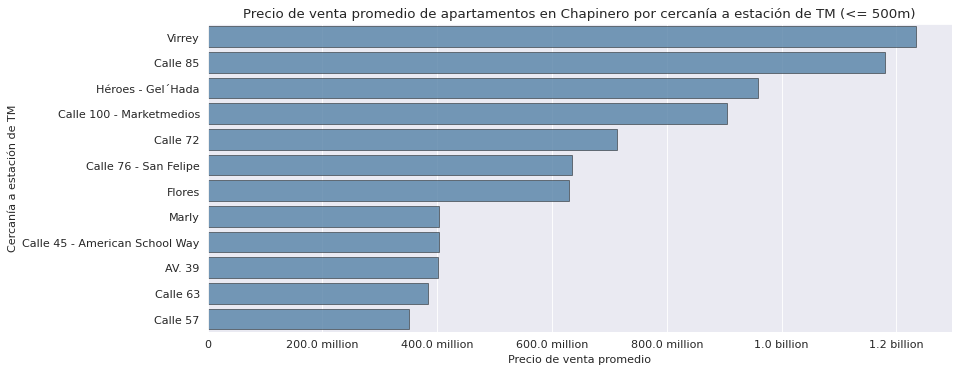

In [56]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_mean,
    y=estacion_tm_cercana_stats_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

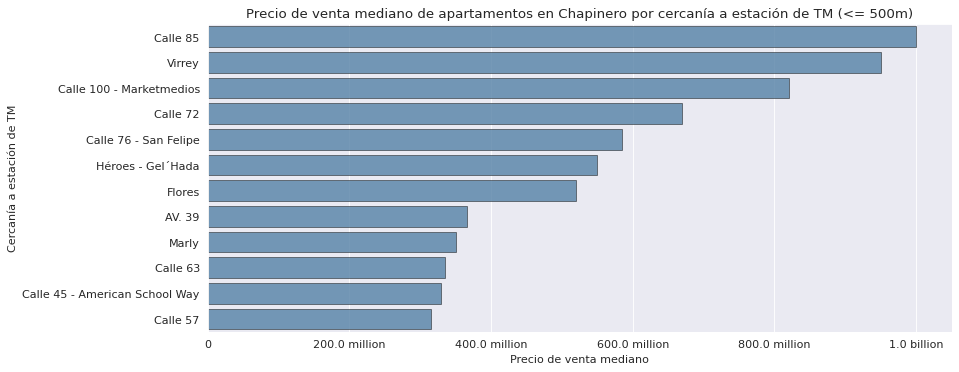

In [57]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_median,
    y=estacion_tm_cercana_stats_median.index,
    x='50%',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta mediano de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

<Figure size 960x400 with 0 Axes>

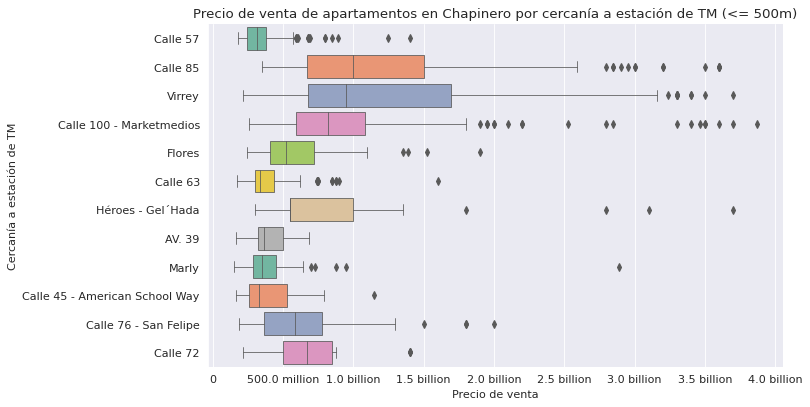

In [58]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='precio_venta',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Precio de venta de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Precios Anteriores Vs Actuales

## Antiguedad

In [59]:
chapinero.antiguedad.value_counts()

antiguedad
MAS DE 20 ANOS        5171
ENTRE 10 Y 20 ANOS    2591
ENTRE 5 Y 10 ANOS     1889
ENTRE 0 Y 5 ANOS      1754
REMODELADO             447
Name: count, dtype: int64

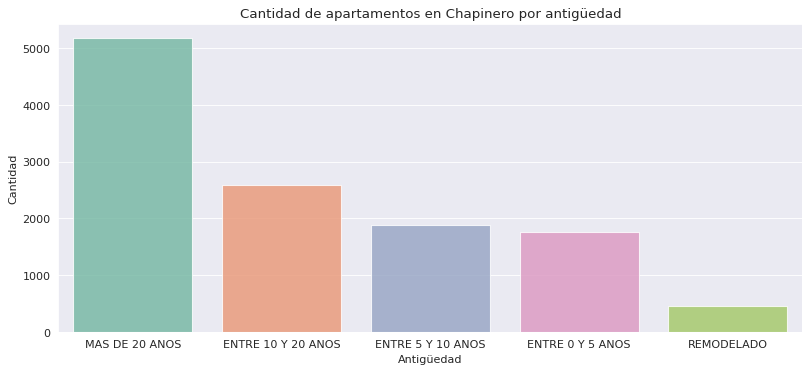

In [60]:
plt.figure(figsize=(12, 5))

sns.countplot(
    chapinero,
    x='antiguedad',
    order=chapinero.antiguedad.value_counts().index,
    palette='Set2',
    # edgecolor='black',
    # linewidth=.5,
    alpha=.8,
)

plt.title('Cantidad de apartamentos en Chapinero por antigüedad')
plt.xlabel('Antigüedad')
plt.ylabel('Cantidad')
plt.show()

### Barrios

In [61]:
chapinero.groupby('antiguedad')['barrio'].describe()

count unique                          top freq
antiguedad                                                       
ENTRE 0 Y 5 ANOS    1754     53             S.C. CHICO NORTE  221
ENTRE 10 Y 20 ANOS  2591     68             S.C. CHICO NORTE  359
ENTRE 5 Y 10 ANOS   1889     63             S.C. CHICO NORTE  251
MAS DE 20 ANOS      5171     72  S.C. CHICO NORTE III SECTOR  521
REMODELADO           447     50              S.C. BELLAVISTA   53

In [62]:
chapinero.groupby('antiguedad')['area'].describe().apply(lambda x: round(x,1))

count   mean   std   min    25%    50%    75%    max
antiguedad                                                               
ENTRE 0 Y 5 ANOS    1754.0  124.7  74.2   1.0   62.1  113.0  171.7  404.0
ENTRE 10 Y 20 ANOS  2591.0  163.2  82.8   8.0   95.0  150.0  220.0  408.0
ENTRE 5 Y 10 ANOS   1889.0  147.4  77.6   6.9   81.4  135.0  200.0  381.2
MAS DE 20 ANOS      5171.0  180.4  82.8   4.0  116.0  170.0  237.3  410.0
REMODELADO           447.0  190.0  86.2  26.0  130.0  191.0  240.7  406.0

In [63]:
chapinero.groupby('barrio')['antiguedad'].describe().sort_values(by='count', ascending=False).head(10)

count unique                 top freq
barrio                                                           
S.C. CHICO NORTE             1392      5      MAS DE 20 ANOS  516
S.C. CHICO NORTE III SECTOR  1098      5      MAS DE 20 ANOS  521
LOS ROSALES                  1059      5      MAS DE 20 ANOS  521
S.C. EL CHICO                1054      5      MAS DE 20 ANOS  364
S.C. BELLAVISTA               758      5      MAS DE 20 ANOS  423
S.C. ANTIGUO COUNTRY          558      5    ENTRE 0 Y 5 ANOS  183
LA CABRERA                    546      5      MAS DE 20 ANOS  263
S.C. EL NOGAL                 482      5      MAS DE 20 ANOS  319
CHICO RESERVADO               474      5  ENTRE 10 Y 20 ANOS  157
EL REFUGIO                    433      5  ENTRE 10 Y 20 ANOS  127

### Estrato

## Barrios

In [64]:
chapinero.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10)

codigo
barrio                             
S.C. CHICO NORTE               1393
S.C. CHICO NORTE III SECTOR    1098
LOS ROSALES                    1060
S.C. EL CHICO                  1054
S.C. BELLAVISTA                 760
S.C. ANTIGUO COUNTRY            558
LA CABRERA                      546
S.C. EL NOGAL                   482
CHICO RESERVADO                 474
EL REFUGIO                      434

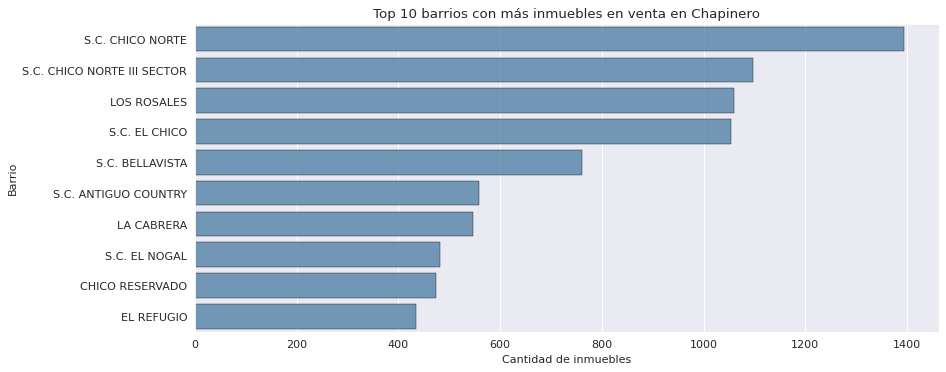

In [65]:
plt.figure(figsize=(12, 5))

sns.barplot(
    data=chapinero.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10),
    x='codigo',
    y=chapinero.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10).index,
    # palette='Set2',
    color='steelblue',
    orient='h',
    edgecolor='black',
    linewidth=.4,
    alpha=.8
)

plt.title('Top 10 barrios con más inmuebles en venta en Chapinero')
plt.xlabel('Cantidad de inmuebles')
plt.ylabel('Barrio')
plt.show()